In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import networkx as nx
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.semi_supervised import _label_propagation
import argparse
import os

In [28]:
dataset = Planetoid(root=r"/home/ray/code/python/python_data_course/机器学习与深度学习导论/data/", name="Cora")

In [29]:
# 查看数据的基本情况
print("网络数据包含的类数量:",dataset.num_classes)
print("网络数据边的特征数量:",dataset.num_edge_features)
print("网络数据边的数量:",dataset.data.edge_index.shape[1]/2) # 除以2是OOC的组织形式
print("网络数据节点的特征数量:",dataset.num_node_features)
print("网络数据节点的数量:",dataset.data.x.shape[0])

网络数据包含的类数量: 7
网络数据边的特征数量: 0
网络数据边的数量: 5278.0
网络数据节点的特征数量: 1433
网络数据节点的数量: 2708


/home/ray/code/test/PDE/PeRCNN/percnn/lib/python3.8/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


In [30]:
CoraNet = to_networkx(dataset.data)
CoraNet = CoraNet.to_undirected()
# 查看网络情况
print("网络的边的数量: ",CoraNet.number_of_edges())
print("网络的节点的数量: ",CoraNet.number_of_nodes())
Node_class=dataset.data.y.data.numpy()
print("节点分类:",Node_class)

网络的边的数量:  5278
网络的节点的数量:  2708
节点分类: [3 4 4 ... 3 3 3]


In [31]:
Node_degree = pd.DataFrame(data=CoraNet.degree, columns=["Node", "Degree"])
Node_degree = Node_degree.sort_values(by=["Degree"], ascending=False)
Node_degree = Node_degree.reset_index(drop=True)

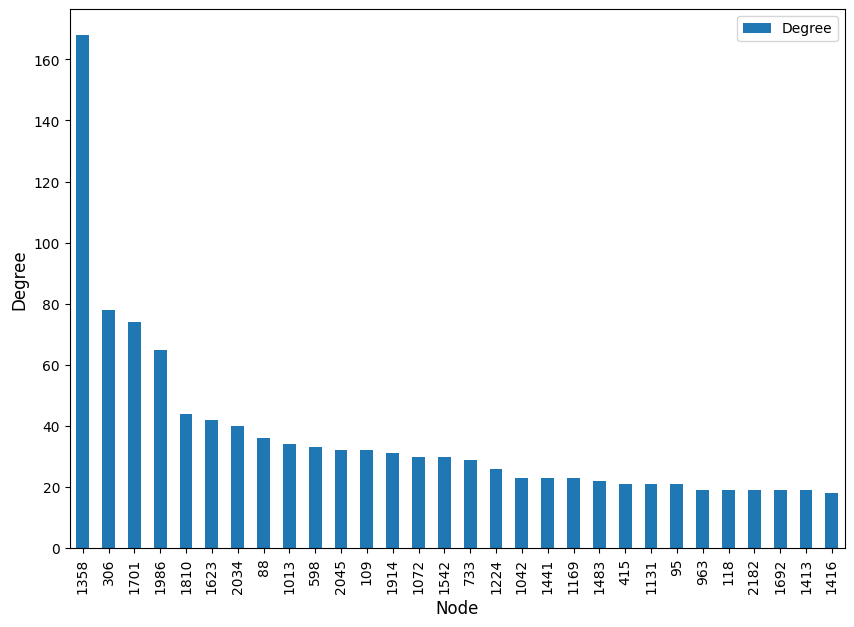

In [32]:
Node_degree.iloc[0:30,:].plot(x="Node",y="Degree",kind="bar",figsize=(10,7))
plt.xlabel("Node", size=12)
plt.ylabel("Degree", size=12)
plt.show()

In [33]:
# # nx图结构可视化
# pos=nx.spring_layout(CoraNet) # 网络图中节点的布局方式
# nodecolor=["red","blue","green","yellow","peru","violet","cyan"]
# nodelabel=np.array(list(CoraNet.nodes))
# plt.figure(figsize=(16,12))

# # 不同的类使用不同的颜色
# for ii in np.arange(len(np.unique(Node_class))):
#     nodelist=nodelabel[Node_class==ii]
#     # 绘制节点
#     nx.draw_networkx_nodes(CoraNet,pos,nodelist=list(nodelist),node_size=20,
#                            node_color=nodecolor[ii],alpha=0.8)

# # 为网络添加边
# nx.draw_networkx_edges(CoraNet,pos,width=1,edge_color="gray")
# plt.show()

In [34]:
# # 可视化训练集的节点分布
# nodelabel=np.arange(0,140) # 训练集节点位置
# Node_class=dataset.data.y.data.numpy()[0:140]
# # nx可视化
# plt.figure(figsize=(8,6))
# for ii in np.arange(len(np.unique(Node_class))):
#     nodelist=nodelabel[Node_class==ii]
#     # 绘制节点
#     nx.draw_networkx_nodes(CoraNet,pos,nodelist=list(nodelist),node_size=20,
#                            node_color=nodecolor[ii],alpha=0.8)
# plt.show()

In [35]:
class GCNNet(torch.nn.Module):
        def __init__(self,input_feature,num_classes):
            super(GCNNet, self).__init__()
            self.input_feature=input_feature
            self.num_classes=num_classes
            # 1433->32
            self.conv1=GCNConv(input_feature, 64)
            # 32->num_classes
            self.conv2=GCNConv(64, num_classes)

        def forward(self,data):
            x,edge_index=data.x,data.edge_index
            # 需要输入的是节点的数据(index,feature)
            # 以及边索引COO，用于构建邻接矩阵和入度矩阵
            x=F.relu(self.conv1(x,edge_index))
            x=F.relu(self.conv2(x,edge_index))
            return F.softmax(x,dim=1)


In [36]:
def parse_args():
    '''PARAMETERS'''
    parser=argparse.ArgumentParser("GCN")
    parser.add_argument('-e','--epochs',type=int,default=500,help='number of epoch in training [default: 200]')
    parser.add_argument('-lr','--learning_rate',type=float,default=0.01, help='learning rate in training [default: 0.01]')
    parser.add_argument('-op','--optimizer',type=str, default='Adam', help='optimizer for training [default: Adam]')
    parser.add_argument('-g','--gpu',type=str, default='0', help='specify gpu device [default: 0]')
    parser.add_argument('-p','--path',type=str, default='./saved', help='the path of file saving [default: ./save]')
    parser.add_argument('-dr','--decay_rate', type=float, default=5e-4, help='decay rate [default: 5e-4]')

    return parser.parse_args(args=[])

In [37]:
args = parse_args()
savepath = args.path
if not os.path.exists(savepath):
    os.makedirs(savepath)

input_feature = dataset.num_node_features
num_classes = dataset.num_classes
data = dataset[0]
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu

model = GCNNet(input_feature, num_classes)

if args.optimizer == 'Adam':
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=args.learning_rate,
        betas=(0.9, 0.999),
        eps=1e-08,
        weight_decay=args.decay_rate
    )
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 读取模型
try:
    checkpoint=torch.load(savepath+"/best_model.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint['epoch']
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
except:
    start_epoch=0

# 网络训练
train_loss_all=[]
val_loss_all=[]
best_acc=0
train_acc_all=[]
model.train()

GCNNet(
  (conv1): GCNConv(1433, 64)
  (conv2): GCNConv(64, 7)
)

In [38]:
for epoch in range(start_epoch, args.epochs):
    optimizer.zero_grad()
    out = model(data)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    train_loss_all.append(loss.data.cpu().numpy())

    loss=F.cross_entropy(out[data.val_mask],data.y[data.val_mask])
    val_loss_all.append(loss.data.cpu().numpy())
    _, pred = out.max(dim=1)
    acc=float(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())/data.train_mask.sum().item()
    train_acc_all.append(acc)

    if acc>best_acc:
        sp=savepath+"/best_model.pth"
        state={
            "epoch":epoch,
            "accuracy":acc,
            "model_state_dict":model.state_dict(),
            "optimizer_state_dict":optimizer.state_dict()
        }
        torch.save(state, sp)
        best_acc = acc

    if epoch%20==0:
        print("Epoch:",epoch,";Train Loss:",train_loss_all[-1],";Val Loss:",val_loss_all[-1],"Train acc:",train_acc_all[-1])


Epoch: 0 ;Train Loss: 1.9457227 ;Val Loss: 1.9449805 Train acc: 0.14285714285714285
Epoch: 20 ;Train Loss: 1.2866781 ;Val Loss: 1.4829557 Train acc: 0.9214285714285714
Epoch: 40 ;Train Loss: 1.2889302 ;Val Loss: 1.4935606 Train acc: 0.9
Epoch: 60 ;Train Loss: 1.2856233 ;Val Loss: 1.4899989 Train acc: 0.9214285714285714
Epoch: 80 ;Train Loss: 1.284711 ;Val Loss: 1.4851586 Train acc: 0.9
Epoch: 100 ;Train Loss: 1.28408 ;Val Loss: 1.483445 Train acc: 0.9142857142857143
Epoch: 120 ;Train Loss: 1.2838014 ;Val Loss: 1.4819201 Train acc: 0.9214285714285714
Epoch: 140 ;Train Loss: 1.1773275 ;Val Loss: 1.4402927 Train acc: 1.0
Epoch: 160 ;Train Loss: 1.1753246 ;Val Loss: 1.4309118 Train acc: 1.0
Epoch: 180 ;Train Loss: 1.1734064 ;Val Loss: 1.4304141 Train acc: 1.0
Epoch: 200 ;Train Loss: 1.1729169 ;Val Loss: 1.4296203 Train acc: 1.0
Epoch: 220 ;Train Loss: 1.172746 ;Val Loss: 1.4297144 Train acc: 1.0
Epoch: 240 ;Train Loss: 1.172663 ;Val Loss: 1.4305748 Train acc: 1.0
Epoch: 260 ;Train Loss: 1.

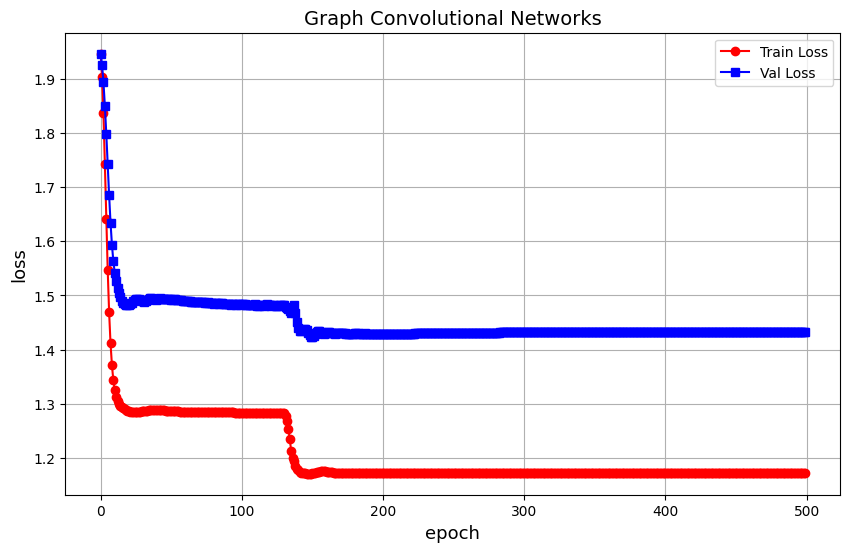

In [39]:
# 可视化损失函数变化
plt.figure(figsize=(10,6))
plt.plot(train_loss_all,"ro-",label="Train Loss")
plt.plot(val_loss_all,"bs-",label="Val Loss")
plt.legend()
plt.grid()
plt.xlabel("epoch",size=13)
plt.ylabel("loss",size=13)
plt.title("Graph Convolutional Networks",size=14)
plt.show()


In [40]:
def draw(x_tsne,t):
    plt.figure(figsize=(12, 8))
    axl = plt.subplot(1, 1, 1)
    X = x_tsne[:, 0]
    Y = x_tsne[:, 1]
    axl.set_xlim([min(X), max(X)])
    axl.set_ylim([min(Y), max(Y)])

    for ii in range(x_tsne.shape[0]):
        text = data.y.data.numpy()[ii]
        axl.text(X[ii], Y[ii], str(text), fontsize=5,
                    bbox=dict(boxstyle="round", facecolor=plt.cm.Set1(text), alpha=0.7))

    axl.set_xlabel("TSNE Feature 1", size=13)
    axl.set_xlabel("TSNE Feature 2", size=13)
    axl.set_title(t, size=15)
    plt.show()


/home/ray/code/test/PDE/PeRCNN/percnn/lib/python3.8/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


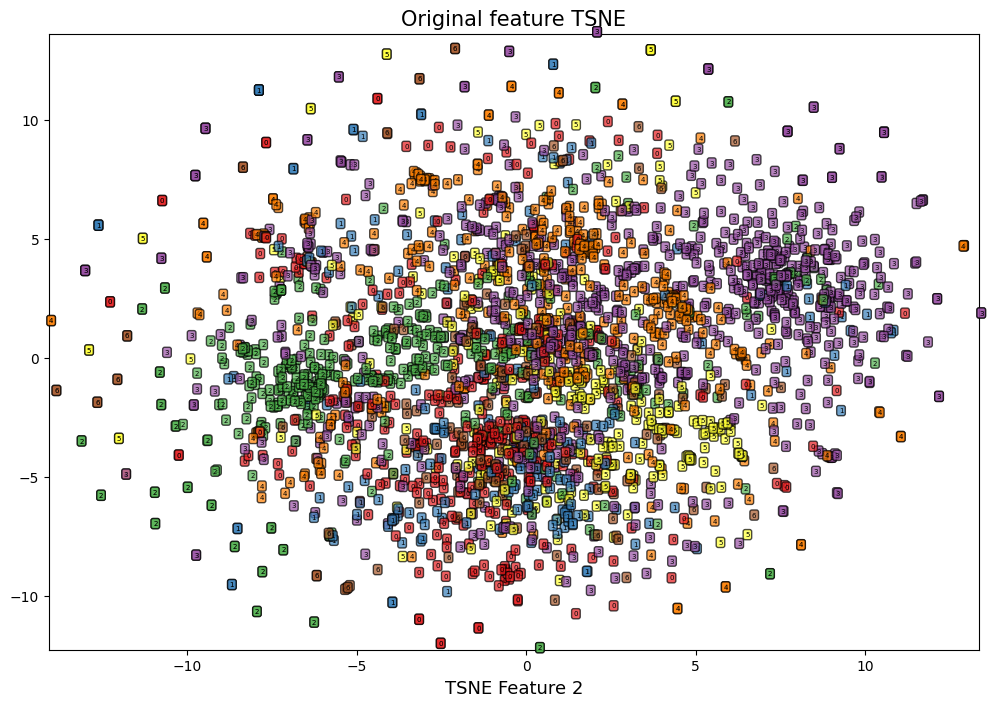

In [41]:
x_tsne = TSNE(n_components=2).fit_transform(dataset.data.x.data.numpy())
draw(x_tsne, "Original feature TSNE")

In [42]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [46]:
model.conv1.register_forward_hook(get_activation("conv1"))
model.conv2.register_forward_hook(get_activation("conv2"))
_ = model(data)
conv1 = activation["conv1"].data.cpu().numpy()
conv2 = activation["conv2"].data.cpu().numpy()
print(conv1.shape)
print(conv2.shape)

(2708, 64)
(2708, 7)


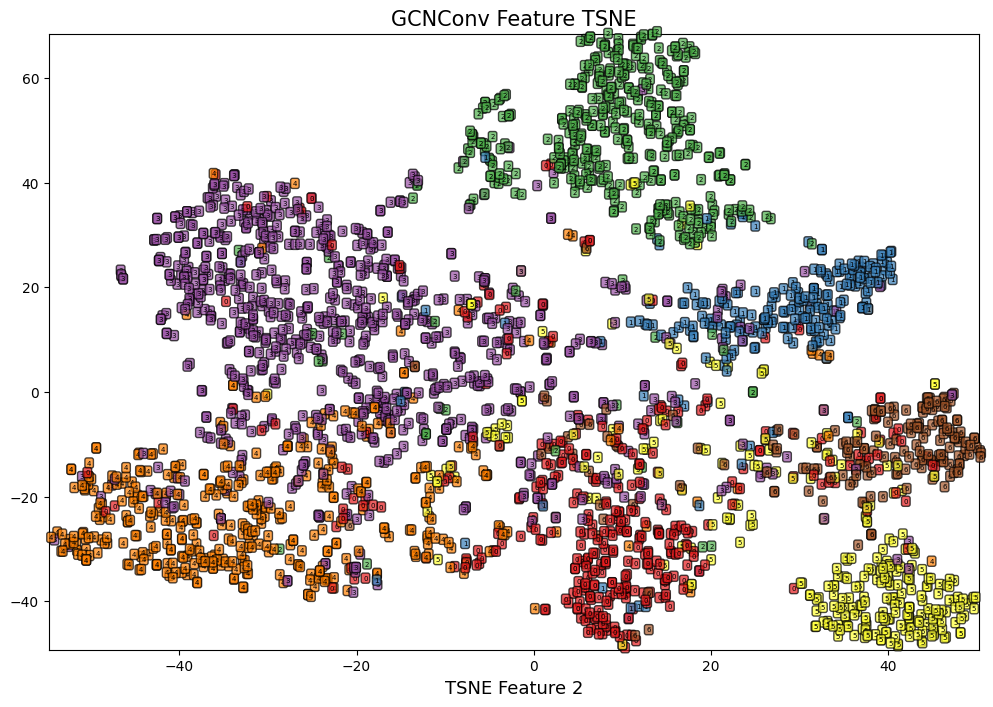

In [45]:
x_tsne=TSNE(n_components=2).fit_transform(conv1)
draw(x_tsne,"GCNConv Feature TSNE")

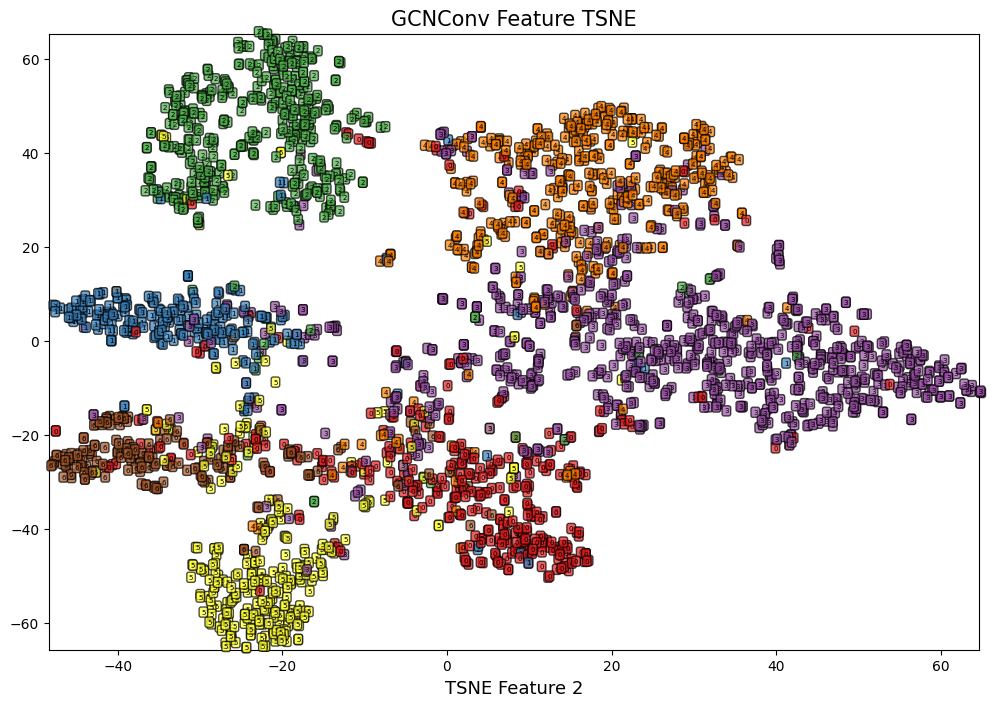

In [47]:
x_tsne=TSNE(n_components=2).fit_transform(conv2)
draw(x_tsne,"GCNConv Feature TSNE")

In [48]:
# 使用SVM进行计算
X=dataset.data.x.data.numpy()
Y=dataset.data.y.data.numpy()

train_mask=dataset.data.train_mask.data.numpy()
test_mask=dataset.data.test_mask.data.numpy()

train_x=X[:140,:]
train_y=Y[train_mask]
test_x=X[1708:2709,:]
test_y=Y[test_mask]

svmmodel=SVC()
svmmodel.fit(train_x,train_y)
prelab=svmmodel.predict(test_x)
print("SVM的预测精度：",accuracy_score(test_y,prelab))

# 使用LabelPropagation模型进行计算

# 对于不是有监督的训练数据的样本标签使用-1表示
train_y=Y.copy()
train_y[test_mask==True]=-1
# 预测数据
test_y=Y[test_mask]
lp_model=_label_propagation.LabelPropagation(kernel="knn",n_neighbors=3)
lp_model.fit(X,train_y)
prelab=lp_model.transduction_
print("LP模型的预测精度：",accuracy_score(Y[test_mask],prelab[test_mask]))

/home/ray/code/test/PDE/PeRCNN/percnn/lib/python3.8/site-packages/torch_geometric/data/in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


SVM的预测精度： 0.56
LP模型的预测精度： 0.435
